# Nested H-score: Computing Maximal Correlation Functions with Deep Learning

This short script illustrates how to extract maximal correlation functions with deep learning, based on the **nested H-score**. 

For convenience, we will use a sythesized discrete dataset, and compare the learned features with the theoretical maximal correlation functions.




## 1. Theoretical Values of Maximal Correlation Functions


We first define the generating law $P_{XY}$ of our data. 



In [ ]:
import numpy as np

# cardinalities           
x_card, y_card = (8, 6)

# randomly pick joint distribution, normalize
p_xy = np.random.random([y_card, x_card])
p_xy = p_xy / np.sum(p_xy)

Before our experiemnts in training some networks, we will define an oracle class, which is a toolbox that provides us the theoretical prediction of training results --- including learned featurs, and converged value of losses.

Here the python class is used to make sure all the theoretical/underlying parameters can be called only through the toolbox. The variable p_xy will be "released(deleted)" to prevent cheating.

In [ ]:
class oracle:
    def get_margins(self, p_mat):
        return np.sum(p_mat, axis = 0), np.sum(p_mat, axis = 1)
    def p2bt(self, p_mat):
        p_x, p_y = self.get_margins(p_mat)
        p_x = p_x.reshape(1, -1)
        p_y = p_y.reshape(-1, 1)
        bt_mat = p_mat / np.sqrt(p_x) / np.sqrt(p_y) - np.sqrt(p_y) * np.sqrt(p_x)
        bt_mat[np.isnan(bt_mat)] = 0
        return bt_mat
    def loss(self, dim):
        # predict the theretical value of loss
        w_vec = dim - np.array(range(dim))
        val = - np.sum(w_vec * (self.sigma[:dim] ** 2))
        val = val / 2
        return val
    def __init__(self, p_mat):
        self.p_xy = p_mat
        # compute marginals
        self.p_x, self.p_y = self.get_margins(p_xy)
        self.Bt = self.p2bt(p_xy)
        '''
        Compute oracleal answers for f and g, corresponding to the 1st pair
        of singular vectors of B
        '''
        Psi, self.sigma, Phi = np.linalg.svd(self.Bt)
        Phi = Phi.T
        self.f = Phi / np.sqrt(self.p_x).reshape(-1, 1)
        self.g = Psi / np.sqrt(self.p_y).reshape(-1, 1)

orc = oracle(p_xy)

The toolbox basically computes a matrix $\tilde{B}$ (known as the canonical dependency matrix, CDM) with entries
$$\tilde{B}(y, x) = \frac{P_{XY}(x, y) - P_X(x)P_Y(y)}{\sqrt{P_X(x)P_Y(y)}}$$
and its SVD
$$\tilde{B}(y, x) = \sum_{i = 1}^K \sigma_i \psi_i^*(y) \phi_i^*(x).$$

Then, the maximal correlation functions $f_i^*, g_i^*$ of $(X, Y)$ can be represented as
$$ 
f_i^*(x) = \frac{\phi_i^*(x)}{\sqrt{P_X(x)}}, \quad g_i^*(y) = \frac{\psi_i^*(y)}{\sqrt{P_Y(y)}}
$$
and we have $\mathbb{E}[f_i^*(X) g_i^*(Y)] = \sigma_i$.

## 2. Learning Maximal Correlation Functions




### 2.1 Generate Samples

Then we generate samples according to $P_{XY}$.

In [ ]:

"""
Generate random discrete samples
"""
def GenerateDiscreteSamples(p_xy, nSamples):
    '''    
    generate n samples of (X, Y) pairs, with distribution p_xy
    
    return a list of two np.array(dtype=int), each of size n
    values in range(cX) and range(cY)
    
    as i.i.d. sample of (X,Y) pairs with joint distribution randomly chosen
    Input:    p_xy, a cY x cX matrix

    '''        
    (y_card, x_card) = p_xy.shape
    p_xy_vec = p_xy.reshape(-1)  # p_xy_vec is the PMF of key = Y * cX + X 
    key = np.random.choice(range(x_card*y_card), nSamples, p=p_xy_vec)
    """
    key = Y * cX + X, p_xy[Y, X] = p_xy_vec[Y * cX + X], shown as follows:
    
    [[       0,            1,  ...,            cX-1], 
     [      cX,       cX + 1,  ...,       cX + cX-1],
     [     2cX,      2cX + 1,  ...,      2cX + cX-1],
            |          |       ...,          |
     [(cY-1)cX, (cY-1)cX + 1,  ..., (cY-1)cX + cX-1]]
    
    """
    Y = (key / x_card).astype(int)
    X = (key % x_card)
    
    return([X, Y])


nSamples = 100000

[X, Y] = GenerateDiscreteSamples(p_xy, nSamples)

# convert X and Y to onehot labels
x_train = np.eye(x_card)[X]
y_train = np.eye(y_card)[Y]

We then delete the variable p_xy to guarantee that all information of the  joint distribution $P_{XY}$ can only be obtained from either the oracle toolbox or the training data. 


In [ ]:
p_xy = None

Suppose we are going to extract the first 5 maximally correlated function pairs, and set

In [ ]:
dim = 5 # dimensions of extratcted feature

### 2.2 Compute Nested H-score

Given $k$-dimensional features $f$ of $X$ and $g$ of $Y$, the H-score $\mathscr{H}(f, g)$ is defined as
\begin{align*}
   \mathscr{H}(f, g) = \mathbb{E}[\langle f(X),  g(Y)\rangle] - \langle \mathbb{E}[f(X)],  \mathbb{E}[g(Y)] \rangle - \frac 12 \mathrm{tr}\left(\mathbb{E}[f(X)f^{\mathrm{T}}(X)]\cdot \mathbb{E}[g(Y)g^{\mathrm{T}}(Y)]\right)
\end{align*}




In [ ]:
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, Activation, Input, Lambda

# obtain the normalized feature by subtracting the mean
tilde_K = lambda x: x - K.mean(x, axis = 0)
# compute the covariance
cov = lambda x: K.dot(K.transpose(x), x) / K.cast(K.shape(x)[0] - 1, dtype = 'float32')

def neg_hscore(x):
    """
    """
    f, g = x
    # subtract the mean
    f0 = tilde_K(f)
    g0 = tilde_K(g)
    # compute correlation
    corr = K.mean(K.sum(f0 * g0, axis = 1))
    # compute covariances 
    # (indeed is E[f f.T], not centered, for extracting zero-mean features) 
    cov_f = cov(f)
    cov_g = cov(g)
    # negative H-score
    neg_h = - corr + K.sum(cov_f * cov_g) / 2
    return neg_h

Then, the nested H-score is defined as
\begin{align*}
   \mathscr{H}^{\perp}(f, g) = \sum_{i = 1}^k \mathscr{H}(f_{[i]}, g_{[i]}),
\end{align*}
where $f_{[i]} \triangleq [f_1, \dots, f_i]^\mathrm{T}$ is the feature composed of the first $i$-dimensions of $f$.



It can be verified that the functions $f = (f_1, \dots, f_k), g = (g_1, \dots, g_k)$ that maximize the nested H-score would satisfy
$$f_i = a_i \cdot f_i^*, \quad g_i  = b_i \cdot g_i^*$$
where $a_i, b_i$ are scalars with $a_i \cdot b_i = \sigma_i$.


The nested H-score $\mathscr{H}^{\perp}$ can be simply computed as the cumulative sum of H-score:

In [ ]:
def neg_hscore_nest(x):
    """
    compute the (nagative) nested H-score
    """
    f, g = x
    dim = f.shape[1]
    neg_h_nest = K.sum([neg_hscore([f[:, :i+1], g[:, :i+1]]) for i in range(dim)])
    return neg_h_nest

### 2.3 Training
We then define our network architectures. Since both $X$ and $Y$ are discrete, it suffices to use one fully-connected layers (Dense() function in Keras) for generating features $f$ and $g$.

In [ ]:
"""
Define the learning model
"""
# one-hot inputs
input_x = Input(shape = (x_card, ))
input_y = Input(shape = (y_card, ))

# using one embedding layer to generate features f and g
# Note that they are not to be activated, as the linear layer already has full 
#         capbablity in express any feature of (one-hot) input
f = Dense(dim)(input_x)
g = Dense(dim)(input_y)

loss = Lambda(neg_hscore_nest)([f, g])
model = Model(inputs = [input_x, input_y], outputs = loss)


Before training the model, let's print the theoretic prediction of the converged (optimal) loss:       


In [ ]:
# before the training, let's see the theoretical value of optimal loss
print('theoretical value of loss =', orc.loss(dim))

theoretical value of loss = -0.43669003136174406


We then train the model. In most cases, the model should converge within 20 epochs though I set it to 100 here.

In [ ]:
""" training parameters """
epochs = 100  
batch_size = 128

model.compile(optimizer='adam', loss = lambda y_true, y_pred: y_pred)

# train the model
hist = model.fit([x_train, y_train],
               np.zeros([x_train.shape[0], 1]),
               batch_size = batch_size,
               epochs = epochs, verbose = 0)

print("trained loss =", hist.history['loss'][-1])

trained loss = -0.42814719676971436


If you run 100 epochs as I did, the final loss value should be close to the oracle's prediction. We then extract the learned features, by feeding all possible one-hoted inputs (identity matrices) to the networks.

In [ ]:
# define new models to obtain the trained features f and g
model_f = Model(inputs = input_x, outputs = f)
model_g = Model(inputs = input_y, outputs = g)

f_learned = model_f.predict(np.eye(x_card))
g_learned = model_g.predict(np.eye(y_card))

## 3. Compare with Theoretical Results
Let's check if we have obtained the features as expected. For this purpose, we will 
1.   compute the the angles between trained features and the maximal correlation functions;
2.   compare trained maximal correlations and theoretical ones;
3.   compare trained maximal correlation functions with the theoretical ones.



### 3.1 Angles between Features

First, we define the function to compute angle between vectors. 

In [ ]:
"""
compute angle (cosine value) between two vectors
"""
def cos(v1, v2):
    """
    Input: v1, v2
    Output:
                      <v1, v2>
     cos(v1, v2) =  -------------
                    ||v1|| ||v2||

    """
    def ip(v1, v2): # compute inner product <v1, v2>
        return np.sum(v1 * v2)    
    return ip(v1, v2) / np.linalg.norm(v1) / np.linalg.norm(v2)


The angles are shown as follows, and you shall see two lists of $\pm 0.99$'s! 😆


In [ ]:
print('cos(f, f*) =', [cos(f_learned[:, i], orc.f[:, i]) for i in range(dim)])
print('cos(g, g*) =', [cos(g_learned[:, i], orc.g[:, i]) for i in range(dim)])

cos(f, f*) = [-0.9995477921600686, 0.9955019201876828, -0.9957371918349666, -0.9728565972625524, 0.9651743921081771]
cos(g, g*) = [-0.9997775324790712, 0.9964110224185853, -0.9947678791588546, -0.9905934545927779, 0.9821218518386047]



Sometimes you may find there are some values not very close to 0.99, e.g., 0.90. This happens when the singular value gaps of $\tilde{B}$ are rather small, which makes the reconstruction of singular vectors of $\tilde{B}$ (maximal correlation functions) ill-posed.



### 3.2 Maximal Correlations (Singular Values of $\tilde{B}$)

Let's take a look at the singular values of $\tilde{B}$:

In [ ]:
print('singular values (oracle):', orc.sigma)

singular values (oracle): [3.45018798e-01 2.07745159e-01 1.71948876e-01 7.94080321e-02
 6.51727082e-02 7.01042352e-17]


Instead of using our oracle's toolbox, we may also retrieve the singular values from our learned features, since we have 
\begin{align*}
\mathbb{E}[f_i(X) g_i(Y)] = \sigma_i \cdot \mathbb{E}[f_i^*(X) g_i^*(Y)]= \sigma_i^2.
\end{align*}
So it suffcies to extract features, and compute their correaltion:     

In [ ]:
f_ensemble = model_f.predict(x_train)
g_ensemble = model_g.predict(y_train)
corr = np.mean(f_ensemble * g_ensemble, axis = 0)

Then, we can check if our estimated maximal correlations those obtained from oracle (theoretical predictions).

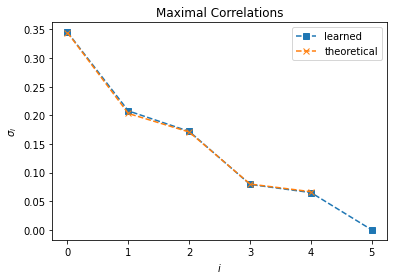

In [ ]:
# learned value of sigma
simga = np.sqrt(corr)

import matplotlib.pyplot as plt
plt.figure()
plt.title('Maximal Correlations')
plt.xlabel('$i$')
plt.ylabel('$\sigma_i$')
plt.plot(orc.sigma, 's--')
plt.plot(simga, 'x--')
plt.legend(['learned', 'theoretical'])

## 3.3 Plot Maximal Correlation Functions
A more straightforward way is to directly plot the features. To get rid of the annoying scaling factors, we will use the following function to normalize features.

In [ ]:
def normalize(v):
    """
    scale a vector v such that v has unit norm
    and the first entry of v is non-negative
    """
    return np.sign(v[0]) * v / np.linalg.norm(v)

Let's first take a look at the first maximal correlatin function $f_1^*(x)$.

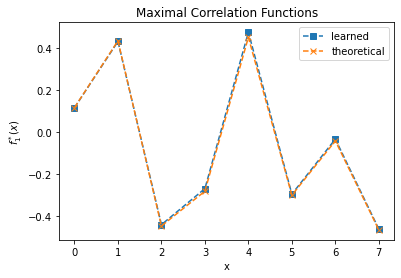

In [ ]:
plt.figure()
plt.title('Maximal Correlation Functions')
plt.xlabel('x')
plt.ylabel('$f_1^*(x)$')
plt.plot(normalize(f_learned[:, 0]), 's--')
plt.plot(normalize(orc.f[:, 0]), 'x--')
plt.legend(['learned', 'theoretical'])

And here is the plot for the third maximal correlatin function  $g_3^*$ of $y$.



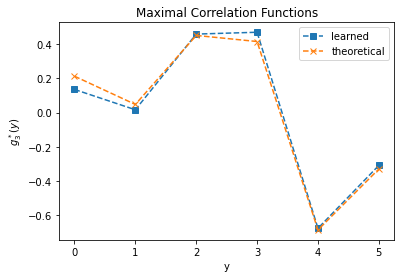

In [ ]:
plt.figure()
plt.title('Maximal Correlation Functions')
plt.xlabel('y')
plt.ylabel('$g_3^*(y)$')
plt.plot(normalize(g_learned[:, 2]), 's--')
plt.plot(normalize(orc.g[:, 2]), 'x--')
plt.legend(['learned', 'theoretical'])